# Yelp Academic dataset
This is the Yelp dataset from Kaggle: https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset.
First let's explore the dataset and see what's in there.

In [21]:
import json
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import numpy as np
from sklearn.cluster import DBSCAN
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import pickle

We are focused on the business and review datasets:

In [22]:
bpath = "/Users/xiyuyi/Desktop/TDI_capstone/TasteFusion/yelp_dataset/yelp_academic_dataset_business.json"
cpath = "/Users/xiyuyi/Desktop/TDI_capstone/TasteFusion/yelp_dataset/yelp_academic_dataset_review.json"

Check how many lines are there in each dataset:

In [16]:
%%time
business_line_count = 0
with open(bpath, 'r') as file:
    while True:
        line = file.readline()
        if line:
            business_line_count+=1
        else:
            break
review_line_count = 0
with open(cpath, 'r') as file:
    while True:
        line = file.readline()
        if line:
            review_line_count+=1
        else:
            break
print('number of lines for business dataset: ' + str(business_line_count))
print('number of lines for review dataset: ' + str(review_line_count))

number of lines for business dataset: 150346
number of lines for review dataset: 6990280
CPU times: user 4.92 s, sys: 1.89 s, total: 6.8 s
Wall time: 7.04 s


check how many businesses are restaurants, and extract all the restaurants, make it into a pandas dataframe

In [61]:
%%time
def is_restaurant(b:dict = None):
    if b['categories']:
        if 'Restaurants' in b['categories']:
            return True
    return False

#find out how many lines are business
num_lines = {'businesses': 150346, 'reviews': 6990280} # take from the previous cell.
restaurants_count = 0
restaurants = []
with open(bpath, 'r') as file:
    for n in range(num_lines['businesses']):
        line = file.readline()
        if line:
            b = json.loads(line)
            if is_restaurant(b):
                restaurants_count += 1
                restaurants.append(b)
print('total number of restaurants in the dataset is:' +str(len(restaurants)))
df_restaurants=pd.DataFrame(restaurants)

total number of restaurants in the dataset is:52268
CPU times: user 1.96 s, sys: 92.5 ms, total: 2.05 s
Wall time: 2.05 s


#### Checkout the geographical distrubition of all the restaurants

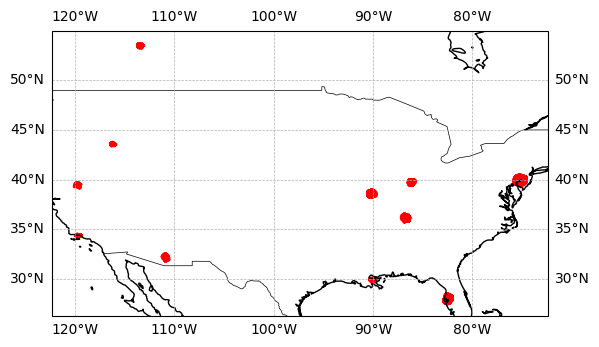

In [76]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
ax.scatter(list(df_restaurants['longitude']), list(df_restaurants['latitude']), s=10, marker='.', color='red', label='Coordinates')
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=0.5)
ax.gridlines(draw_labels=True, linewidth=0.5, linestyle='--')


Now it seems like there are clusters of restaurants being included in this dataset.

In [79]:
%%time
# Perform DBSCAN clustering
eps = 0.5  # This is an example value, adjust it based on your data
min_samples = 5  # This is an example value, adjust it based on your data
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
df_restaurants['group'] = dbscan.fit_predict(df_restaurants[['longitude', 'latitude']])
df_restaurants.head()

CPU times: user 4.29 s, sys: 3.99 s, total: 8.29 s
Wall time: 8.49 s


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,group
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",0
1,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...",1
2,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,"{'Caters': 'True', 'Alcohol': 'u'full_bar'', '...","Pubs, Restaurants, Italian, Bars, American (Tr...",None,2
3,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...",1
4,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'...",3


In [125]:
group_names={0: 'Philadelphia',
             1: 'Nashville',
             2: 'St. Louis',
             3: 'Tampa',
             4: 'Indianapolis',
             5: 'Edmonton',
             6: 'Reno',
             7: 'Tucson',
             8: ' New Orleans',
             9: 'Santa Barbara',
             10: 'Boise'}

### Checkout the cities for these (longitude, latitude) coordinates:
    (-75.203510, 39.999218): Philadelphia, Pennsylvania, USA
    (-86.741565, 36.135339): Nashville, Tennessee, USA
    (-90.278498, 38.638821): St. Louis, Missouri, USA
    (-82.569253, 27.980234): Tampa, Florida, USA
    (-86.156992, 39.813526): Indianapolis, Indiana, USA
    (-113.505682, 53.532330): Edmonton, Alberta, Canada
    (-119.792317, 39.514946): Reno, Nevada, USA
    (-110.937462, 32.242158): Tucson, Arizona, USA
    (-90.100641, 29.958008): New Orleans, Louisiana, USA
    (-119.726130, 34.422738): Santa Barbara, California, USA
    (-116.280300, 43.617730): Boise, Idaho, USA

In [179]:
df_restrns_geogroups=pd.DataFrame()
df_restrns_geogroups['count'] = df_restaurants.groupby('group')['group'].count()
df_restrns_geogroups[['longitude', 'latitude']] = df_restaurants.groupby('group')[['longitude', 'latitude']].mean()
df_restrns_geogroups['group_name'] = df_restrns_geogroups.index.map(group_names)
df_restrns_geogroups['unique cities'] = df_restaurants.groupby('group')['city'].unique()
df_restrns_geogroups['unique cities count'] = df_restrns_geogroups['unique cities'].apply(lambda x: len(x))
df_restrns_geogroups['total review count'] = df_restaurants.groupby('group')['review_count'].sum()
df_restrns_geogroups['range'] = df_restaurants.groupby('group').apply(calculate_range)

In [298]:
# take a look at the groups
df_restrns_geogroups

,count,longitude,latitude,group_name,unique cities,unique cities count,total review count,range
group,,,,,,,,
0,16944,-75.203510,39.999218,Philadelphia,"[Philadelphia, Ardmore, Exton, Bala Cynwyd, We...",494,1271660,66.206641
1,4353,-86.741565,36.135339,Nashville,"[Ashland City, Nashville, White House, Brentwo...",45,423778,45.572534
2,5232,-90.278498,38.638821,St. Louis,"[Affton, Alton, Saint Louis, Fairview Heights,...",129,376612,45.266243
3,8732,-82.569253,27.980234,Tampa,"[Tampa Bay, Largo, Tampa, Wesley Chapel, Treas...",129,763843,64.687495
4,4150,-86.156992,39.813526,Indianapolis,"[Indianapolis, Carmel, Avon, Brownsburg, Noble...",42,323905,34.737625
5,2410,-113.505682,53.532330,Edmonton,"[Edmonton, St Albert, Sherwood Park, Beaumont,...",15,66398,22.704321
6,1673,-119.792317,39.514946,Reno,"[Reno, Sparks, Virginia City, Verdi, Spanish S...",11,232056,31.533112
7,2672,-110.937462,32.242158,Tucson,"[Tucson, Marana, Green Valley, Sahuarita, Vail...",18,255348,43.530321
8,3640,-90.100641,29.958008,New Orleans,"[Harvey, New Orleans, Kenner, Metairie, Westwe...",34,544962,27.645895


In [109]:
%%time
def calculate_range(group_df):
    # Convert degrees to radians for calculation
    group_df['latitude_rad'] = np.radians(group_df['latitude'])
    group_df['longitude_rad'] = np.radians(group_df['longitude'])
    
    # Create a matrix of all coordinates in this group
    coords = group_df[['latitude_rad', 'longitude_rad']].to_numpy()
    
    # Calculate pairwise haversine distances and convert to miles
    distances = haversine_distances(coords, coords) * 3958.8 # Earth radius in miles

    # Return the max distance in the group
    return distances.max()

range_per_group = df_restaurants.groupby('group').apply(calculate_range)

# Display the range in miles for each group
print(range_per_group)

group
0     66.206641
1     45.572534
2     45.266243
3     64.687495
4     34.737625
5     22.704321
6     31.533112
7     43.530321
8     27.645895
9     24.745276
10    21.099775
dtype: float64


# Now choose Reno to move on.

### Extract Review for Reno
Extract all the reviews for restaurants in Reno


In [166]:
df_Reno_restaurants = df_restaurants[df_restaurants['group']==6]

In [168]:
df_Reno_restaurants['latitude_rad'] = df_Reno_restaurants['latitude'].apply(lambda x: np.radians(x))
df_Reno_restaurants['longitude_rad'] = df_Reno_restaurants['longitude'].apply(lambda x: np.radians(x))

/var/folders/7j/hg7sqsbd3lj3htv5vcg1hpdh0000gn/T/ipykernel_1307/3425638911.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Reno_restaurants['latitude_rad'] = df_Reno_restaurants['latitude'].apply(lambda x: np.radians(x))
/var/folders/7j/hg7sqsbd3lj3htv5vcg1hpdh0000gn/T/ipykernel_1307/3425638911.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Reno_restaurants['longitude_rad'] = df_Reno_restaurants['longitude'].apply(lambda x: np.radians(x))


In [167]:
df_Reno_restaurants

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,group
11,9OG5YkX1g2GReZM0AskizA,Romano's Macaroni Grill,5505 S Virginia St,Reno,NV,89502,39.476117,-119.789339,2.5,339,1,"{'RestaurantsGoodForGroups': 'True', 'Restaura...","Restaurants, Italian","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",6
42,knQ4vIgx-r85kjlWVVjcpQ,Silver and Blue Outfitters,5191 Meadowood Mall Cir,Reno,NV,89502,39.476518,-119.784037,4.5,5,1,"{'BikeParking': 'True', 'WiFi': 'u'no'', 'Dogs...","Sporting Goods, Sports Wear, Fashion, Restaura...","{'Monday': '0:0-0:0', 'Tuesday': '10:0-21:0', ...",6
56,Lx8ZYUJ_-3Aa8N821mN1WQ,ALM Kainan,"390 N McCarran Blvd, Ste B",Sparks,NV,89434,39.537179,-119.735532,4.0,13,0,"{'RestaurantsAttire': 'u'casual'', 'HasTV': 'F...","Restaurants, Filipino","{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'...",6
106,Pr_Mlt9FqdcW7WCFGJmozA,The Cider Factory,420 S B St,Virginia City,NV,89440,39.305224,-119.652596,4.5,104,1,"{'RestaurantsGoodForGroups': 'True', 'GoodForK...","Italian, Seafood, American (Traditional), Stea...","{'Monday': '11:0-19:0', 'Tuesday': '11:0-19:0'...",6
139,KdkMXzeoqpfNsZd-_axoTQ,emPIEnada,3683 Kings Row,Reno,NV,89503,39.542835,-119.856911,4.5,41,1,"{'Caters': 'True', 'BikeParking': 'True', 'Alc...","Event Planning & Services, Restaurants, Empana...","{'Tuesday': '11:30-19:0', 'Wednesday': '11:30-...",6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52127,9vxRTTRGxX4EthzqI7QgCw,La Barca Mexican Store,"10603 Stead Blvd, Ste 1",Reno,NV,89506,39.625956,-119.882626,4.0,60,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Arts & Entertainment, Restaurants, Wineries, F...","{'Monday': '8:30-21:30', 'Tuesday': '8:30-21:3...",6
52134,J1XtshftqiJDuWW1hnbs9w,The Jelly Donut,1750 S Virginia St,Reno,NV,89502,39.507035,-119.803481,3.5,71,1,"{'RestaurantsPriceRange2': '1', 'BusinessParki...","Restaurants, Donuts, Food","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",6
52180,y77Rf5aezhj92pi1juN93g,Cielito Lindo Taqueria,3687 Kings Row,Reno,NV,89503,39.542663,-119.858692,4.0,253,1,"{'RestaurantsTakeOut': 'True', 'OutdoorSeating...","Bars, Fast Food, Restaurants, Mexican, Nightli...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-20:0', ...",6
52195,nTEmSvz8_DK-iK3miQFCwA,Great Basin Brewing,846 Victorian Ave,Sparks,NV,89431,39.535095,-119.754133,4.0,580,1,"{'RestaurantsPriceRange2': '2', 'BusinessAccep...","Food, Bars, Restaurants, Brewpubs, Breweries, ...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-21:0', ...",6


In [146]:
%%time
Reno_reviews=[]
business_ids = set(df_Reno_restaurants['business_id'])
# now go through the review jason file, and extract out the lines with restaurant id in Reno_restaurants
review_line_count = 0
with open(cpath, 'r') as file:
    while True:
        line = file.readline()
        if line:
            review = json.loads(line)
            if review['business_id'] in business_ids:
                Reno_reviews.append(review)
        else:
            break

CPU times: user 36.2 s, sys: 2.3 s, total: 38.5 s
Wall time: 39.3 s


### Save out the dataframes for the restaurants and reviews in Reno

In [169]:
# saveout the restaurant and reviews for all restaurants in Reno
with open('df_Reno_restaurants.pkl','wb') as f:
    pickle.dump(df_Reno_restaurants, f)
with open('df_Reno_reviews.pkl','wb') as f:
    pickle.dump(df_Reno_reviews, f)

In [23]:
# saveout the restaurant and reviews for all restaurants in Reno
with open('df_Reno_restaurants.pkl','rb') as f:
    df_Reno_restaurants = pickle.load(f)
with open('df_Reno_reviews.pkl','rb') as f:
    df_Reno_reviews = pickle.load(f)

### How many reviews are there for these restaurants?

In [24]:
import pandas as pd

# Assuming df_restrns_geogroups is your DataFrame
# df_restrns_geogroups = pd.DataFrame(...)

# Sort the DataFrame in descending order of 'review number'
sorted_df = df_Reno_restaurants.sort_values(by='review_count', ascending=False)

# Display the sorted DataFrame
sorted_df[['business_id','review_count']][:50]


,business_id,review_count
39796,J0joPXxmN-_9Lzafspqdbw,2506
24282,ve_-rPlEGPClytyJtY55Vw,1576
30177,ld_H5-FpZOWm_tkzwkPYQQ,1534
19254,Gb5nFcTgOBWeMrmCIbxqJA,1489
49338,lEi0T3m96A2NXXDSn7569A,1293
17488,4_OXOjAUA9Q8L6VdZz692w,1266
13928,rSYyGcZZziJLsqKl5hMcDw,1249
1377,TDKBPcViJQDMrdUm6a9XZA,1245
48247,I_mCFePUG2MGuH-zuws7bA,1227
24360,Z_WZq3uFGqvtjsFl6kNBQA,1164


### Need to filter reviews.
Some restaurants have thousands of reviews, too mcuh to process. 
Take out the review text for one restaurant and try to find a way to filter for reviews for us

    For business_id='J0joPXxmN-_9Lzafspqdbw' there are >2k reviews. look at this one.

In [25]:
target_bid = 'J0joPXxmN-_9Lzafspqdbw'
reviews_oneb = df_Reno_reviews[df_Reno_reviews['business_id'] == target_bid]

In [26]:
# check the total number of reviews for this restaurant
reviews_oneb.shape

(2552, 9)

In [27]:
df = reviews_oneb.sort_values(by='useful',ascending=False)
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
190823,HA0ZLe6xoyRIkrGQ8areXw,K74S1UK7QjAhWnkXIN0nhg,J0joPXxmN-_9Lzafspqdbw,4.0,209,110,205,An American diner with a mixture of Hawaiian a...,2019-10-09 09:27:26
190056,d6bDbRbX4XihIoQ0hSlClg,h4oOQdnfjpEHbygEJDsFbg,J0joPXxmN-_9Lzafspqdbw,2.0,62,44,58,"Our hotel didn't provide us with breakfast, so...",2018-08-21 12:44:56
187864,6mFXzXtSAiOOaHiuN3Stwg,JRAy4P4op3PCISZaMRA9_w,J0joPXxmN-_9Lzafspqdbw,3.0,28,17,22,We were kind of disappointed this morning with...,2018-08-07 16:04:26
181841,5NcGH4OdejpZ0eJDb7SQBA,nC4x02Sv0YYT9CV0UcMSxw,J0joPXxmN-_9Lzafspqdbw,5.0,28,14,25,This got to be my favorite Peg's in Reno every...,2016-03-27 04:27:31
187521,CJ2s8D11ONKR94t0MD8AUg,gVO3VZwCu54Otc7bUB33Mg,J0joPXxmN-_9Lzafspqdbw,4.0,22,11,20,"June 26, 2016 Sunday - 10 AM for Breakfast\n4 ...",2016-06-28 01:01:06


In [28]:
# take a look at one review
print(list(df[100:101]['text'])[0])


ATTENTION HEAVY DRINKERS AND HUNGRY PEOPLE!

This place is for you! 

I have eaten on and off at Peg's for about 3 years, and I've tried all of their locations.  They have huge portions that are great tasting for the price, they are pretty much the best thing ever to cure hunger or hang-overs.  The only downside to this place is that it's so popular you might have to wait.  But once in, service is fast and so is the food.  

I recommend the eggs benedict and the variations (california benedict, florentine benedict, and my personal favorite, the crabcake Benedict!) Also, you cannot go wrong with the Huevos Rancheros, or the pancakes... or really anything.  I try to always order something different, and they have specials every weekend so it's impossible to try it all.  I always get an iced Vanilla chai because it's good, and they have fresh squeezed orange juice and good coffee.  You can't fault these guys, they are great!


even the 100th review seems fine, look at the review lengths.

In [29]:
df['review length'] = df['text'].apply(lambda x: len(x))

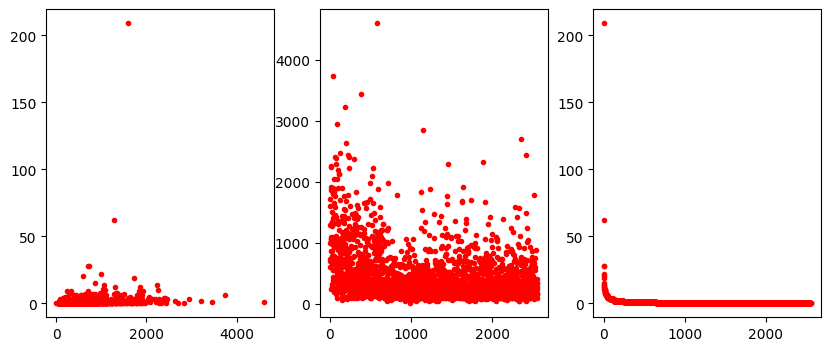

In [30]:
review_lengths = list(df['review length'])
review_useful = list(df['useful'])
plt.figure(figsize=(10,4))
plt.subplot(131)
plt.plot(review_lengths,review_useful,'r.')
plt.subplot(132)
plt.plot(review_lengths,'r.')
plt.subplot(133)
plt.plot(review_useful,'r.')

In [31]:
l=df[df['review_id']=='CRIVPQp5-oxsNFWaCIHSHQ']['text']

In [32]:
print(list(l)[0])

This place came to our rescue after another place was closed! 
They seated us right away and got our food to us quickly. Everything tasted great but I recommend their fries. They are extra crispy, I couldn't  stop eating them.  

Solid breakfast/lunch spot. Make a stop.


### Now try to filter out N or all reviews for a given restaurant

In [33]:
target_bid = 'J0joPXxmN-_9Lzafspqdbw'
def filter_reviews(reviews_df, target_bid, N=100):    
    reviews = reviews_df[df_Reno_reviews['business_id'] == target_bid].sort_values(by='useful',ascending=False)
    output = list(reviews[:N]['text'])
    return output

In [34]:
k=filter_reviews(df_Reno_reviews, target_bid, N=20)
len(k)

20

In [35]:
def flatten_reveiws(reviews_list):
    reviews_paragraph = """
    All the reviews:
    
    """
    for r in reviews_list:
        reviews_paragraph += r
        reviews_paragraph += '\n'
    return reviews_paragraph

In [36]:
o = flatten_reveiws(k[10:])

In [ ]:
# now try to design some prompts to extract information 

## Prompt:
I will give you a list of reviews of a restaurant, and please answer the following questions base don the reviews I give you:
1. give top 5 recommended foods.
2. top 2 not recommended foods.
2. use 5 words to describe what kind of foods are offered at the restaurant
3. use 5 words to describe the tastes of the foods offered att he restaurant.
4. tell me 2 things about this restaurant that most peopel like about it the most.
5. good for breakfast/brunch? answer [yes] or [not mentioend]
6. good for lunch? answer [yes] or [not mentioend]
7. good for dinner? answer [yes] or [not mentioend]
7. good for group of friends? answer [yes] or [not mentioend]
8. use 5 words to describe the accomoations for food resstrictions. If not clearly indicated, say [not mentioned].

Here are the reviews:

[list of reviews]

### Here is the output for top 100 reviews:
    List of (Food Name - Recommended or Not Recommended):
Based on the top 50 foods mentioned, here's a summary:

- Recommended: 
    French Toast, Hawaiian Breakfast, Loco Moco, Ham/Banana Combo, Veggie Omelet, Strawberry Pancakes, Huevos Rancheros, Bananas Foster Belgian Waffle, Steak and Eggs, Country Sausage and Eggs, Sierra Omelette, Chicken Fried Steak, Corned Beef Hash and Eggs, Pancake Sandwich, Nature's Bonanza, Tamale and Eggs.


- Not Recommended:
Biscuits and Gravy (due to flavor and texture issues).

- 5 Words to Describe the Food Offerings:
Diverse, Hearty, American, Hawaiian-Inspired, Comforting.

- 5 Words to Describe the Tastes of the Foods:
Savory, Sweet, Rich, Home-style, Flavorful.


### Here is the output for top 10 reviews:
List of (Food Name - Recommended or Not Recommended):

- Recommended: French Toast (cooked to perfection, enhanced with bananas and maple syrup), Hawaiian Breakfast (hearty and filling), Veggie Omelet (overflowing with veggies), Loco Moco (good overall, best when shared), Bananas Foster Belgian Waffle (excellent sauce, many banana slices), Island Breakfast (pork chops moist and tender, overall amazing), Nature's Bonanza (unique and filling, a healthy option).

- Not Recommended: Biscuits and Gravy (poor biscuit to gravy ratio, lacking in flavor), Hawaiian Breakfast (sausages overcooked and dry).

- 5 Words to Describe the Food Offerings:
Diverse, Flavorful, Hearty, Comforting, Inventive.

- 5 Words to Describe the Tastes of the Foods:
Savory, Sweet, Rich, Balanced, Satisfying.

### Here is additional output for top 10 reviews:

**List of [food name] - Recommended or Not Recommended:**

    Biscuits and Gravy - Not Recommended
    Hawaiian Breakfast - Mixed Reviews (One review not recommended, another recommended)
    French Toast - Recommended
    Loco Moco - Not Recommended
    Peg's Glorified Ham and Eggs - Recommended
    
**Five Words to Describe the Foods Offered:**

    American, Hawaiian, Mexican, Hearty, Classic
   
**Five Words to Describe the Tastes of the Foods:**

    Flavorful, Crispy, Sweet, Savory, Diverse
    
**Two Things People Like Most About the Restaurant:**

    Large Portion Sizes
    Friendly and Attentive Service
    
**Good for Breakfast/Brunch?**

    Yes
**Good for Lunch?**

    Not explicitly mentioned, but likely yes based on the menu and diner style.
    
**Good for Dinner?**

    Not explicitly mentioned, and the focus seems to be on breakfast/brunch.
    
**Good for a Group of Friends?**

    Yes
    
**Five Words to Describe Accommodations for Food Restrictions:**

    General (not specifically indicated in reviews)

### Filter Information in Given range
Given a search radius in Reno, return a refined list of restaurants and their reviews


In [ ]:
search_range = 5 # miles

In [189]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in miles between two points 
    on the earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 

    # Radius of earth in miles is 3958.8
    miles = 3958.8 * c
    return miles



/var/folders/7j/hg7sqsbd3lj3htv5vcg1hpdh0000gn/T/ipykernel_1307/2026104629.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Reno_restaurants['distance'] = df_Reno_restaurants.apply(


In [ ]:
# Provided center coordinate
center_lon, center_lat = -119.8138, 39.5296  # this is center for Reno
range_in_miles = 1  # desired search range in miles


# Calculate distance for each restaurant
df_Reno_restaurants['distance'] = df_Reno_restaurants.apply(
    lambda row: haversine(center_lon, center_lat, row['longitude'], row['latitude']), axis=1)


# Filter rows where distance is within the specified range
df_currentpool_b = df_Reno_restaurants[ df_Reno_restaurants['distance'] <= range_in_miles ]


# df_filtered now contains restaurants within the specified range of the given center coordinate

In [17]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
text = o
tokens = tokenizer.encode(text)
token_count = len(tokens)
print("Number of tokens:", token_count)


/Users/xiyuyi/anaconda3/envs/ds/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
Token indices sequence length is longer than the specified maximum sequence length for this model (3262 > 1024). Running this sequence through the model will result in indexing errors


Number of tokens: 3262


In [188]:
def filter_relevant_reviews(businesses_df, reviews_df):
    filtered_reviews_df = reviews_df[reviews_df['business_id'].isin(businesses_df['business_id'])]
    return filtered_reviews_df

In [191]:
df_currentpool_r =  filter_relevant_reviews(df_currentpool_b, df_Reno_reviews)

In [193]:
df_currentpool_r.shape

(71687, 9)

In [194]:
df_Reno_reviews.shape

(243613, 9)

In [37]:
from tastefusion.utils.gpt_agent import OpenAIAPI
import yaml
path = "/Users/xiyuyi/configs/configs.yaml"
with open(path, 'r') as f:
    configs = yaml.safe_load(f)

a = OpenAIAPI(configs)

In [40]:
_=a.get_prompt_parsing_reviews(reviews=o[:10])
r = a.send()
t=r.choices[0].text.strip()
print(t)

ge food I had here was great. I liked the steak, the salmon, the ribs, the stir fry, and the sandwiches.

Answer:
        Recommended foods: steak, salmon, ribs, stir fry, sandwiches
Not recommended foods: not mentioned
Words to describe what kind of foods offered: steak, salmon, ribs, stir fry, sandwiches
Words to describe the tastes of the foods: delicious, savory, flavorful, juicy, succulent
2 things people like most: great food, variety of dishes
Good for breakfast/brunch: not mentioned
Good for lunch: yes
Good for dinner: yes
Good for groups: yes
Words to describe accommodations for food restrictions: not mentioned


In [203]:
bid1 = 'diwwt5QBU3-Thig9SVlsOA'
bid2 = 'N5QQdPac1cXwOHr-ePr90g'

In [204]:
reviews_1b=df_Reno_reviews[df_Reno_reviews['business_id']==bid2]

In [213]:
for i in reviews_1b['text']:
    print(i)

Delicious food. Fast and friendly service! We had the el jaffe, banana short stack, and breakfast enchiladas. Everything was perfection. The pork enchiladas were to die for! So yummy. And my pancakes were divine. Cooked to perfection. Nice and fluffy, golden brown. Next time I'm in Reno this is where we'll go for breakfast or lunch! The owner and the 2 other guys working were just so friendly too.
The Morning Cuban. It could be renamed "Gout on a Plate," but HOLY $H!T is this open faced breakfast sandwich good. It comes on a thick slice of toasted bread (the type they use for french toast), with roasted pulled pork, swiss cheese, ham, 2 fried eggs on top, with a generous portion of house green salsa slathered over the top, creating a moat of not-too-spicy green goodness. Holy sh!t. This makes me think of "the morning after" breakfast after partying in Miami's South Beach with some bangin Cuban honeys. Yes, it's like THAT. This sh!t is soooo bomb. I kept muttering expletives to myself a

In [224]:
bid='J0joPXxmN-_9Lzafspqdbw'
reviews=df_Reno_reviews[df_Reno_reviews['business_id']==bid]

In [230]:
reviews['review length'] = reviews['text'].apply(lambda x: len(x))

/var/folders/7j/hg7sqsbd3lj3htv5vcg1hpdh0000gn/T/ipykernel_1307/4213817170.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['review length'] = reviews['text'].apply(lambda x: len(x))


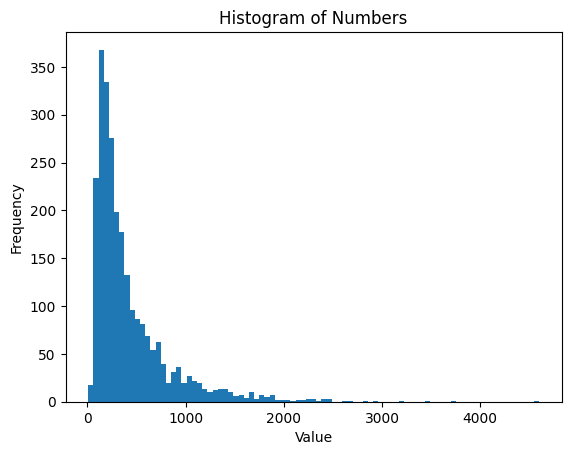

In [235]:
# Plotting the histogram
plt.hist(reviews['review length'], bins='auto')  # 'auto' lets matplotlib decide the number of bins
plt.title('Histogram of Numbers')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [244]:
r = reviews[reviews['review length'] > 250]['text']
r.shape

(1419,)

In [269]:
reviews['review length'].sum()

1094383

In [272]:
reviews.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,review length
167075,t-8_dkEGRdhMJA2e_jhOhA,vyejAy3_QDEZfIwxTp1cig,J0joPXxmN-_9Lzafspqdbw,5.0,0,0,0,Great food and good prices and huge portions!!!,2017-08-07 19:56:37,47
167076,3G1J6pd8ObyyAqKT4ahfnA,71L2kSEPO3IpRunyXuWDDQ,J0joPXxmN-_9Lzafspqdbw,4.0,0,0,0,Good place for breakfast.\n\nHawaiian dishes a...,2017-06-17 17:16:28,167
167082,Qx8fsM-mImRkUYBxzUbLEA,MuYRGtyZz9qoi8_qcr80Ew,J0joPXxmN-_9Lzafspqdbw,4.0,0,0,0,Do it! This place has awesome food and a fast...,2017-07-28 17:52:38,114
167092,Le3G6gzoicIQ0EBtqduzrw,tYa6U8W3MlL8JHQ4yzGfqA,J0joPXxmN-_9Lzafspqdbw,3.0,0,0,0,Gave this place a try because of the stars and...,2017-08-08 00:54:16,1003
167101,ap2ROCMeLSOqoVKAwt1nXA,riBhNRAWj7qcnhTSD16PtQ,J0joPXxmN-_9Lzafspqdbw,5.0,0,0,0,"Truth be told, Reno is not a destination of ch...",2015-07-16 15:56:22,422


In [293]:
usefful_sorted = reviews.sort_values(by='useful', ascending=False)

In [297]:
usefful_sorted[:200]

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,review length
190823,HA0ZLe6xoyRIkrGQ8areXw,K74S1UK7QjAhWnkXIN0nhg,J0joPXxmN-_9Lzafspqdbw,4.0,209,110,205,An American diner with a mixture of Hawaiian a...,2019-10-09 09:27:26,1604
190056,d6bDbRbX4XihIoQ0hSlClg,h4oOQdnfjpEHbygEJDsFbg,J0joPXxmN-_9Lzafspqdbw,2.0,62,44,58,"Our hotel didn't provide us with breakfast, so...",2018-08-21 12:44:56,1284
187864,6mFXzXtSAiOOaHiuN3Stwg,JRAy4P4op3PCISZaMRA9_w,J0joPXxmN-_9Lzafspqdbw,3.0,28,17,22,We were kind of disappointed this morning with...,2018-08-07 16:04:26,726
181841,5NcGH4OdejpZ0eJDb7SQBA,nC4x02Sv0YYT9CV0UcMSxw,J0joPXxmN-_9Lzafspqdbw,5.0,28,14,25,This got to be my favorite Peg's in Reno every...,2016-03-27 04:27:31,704
187521,CJ2s8D11ONKR94t0MD8AUg,gVO3VZwCu54Otc7bUB33Mg,J0joPXxmN-_9Lzafspqdbw,4.0,22,11,20,"June 26, 2016 Sunday - 10 AM for Breakfast\n4 ...",2016-06-28 01:01:06,1003
...,...,...,...,...,...,...,...,...,...,...
191785,VquZU7j9kX-XrDdaE4o0sA,1i6KoGjzSkKo4iDZ5LhkEw,J0joPXxmN-_9Lzafspqdbw,5.0,2,0,1,My wife had the chille relleno with eggs and i...,2010-04-06 22:40:07,598
187806,MYXqnoSAngRByxTLkyRczQ,x3faJIGSF6SQFVCZQ4Zwiw,J0joPXxmN-_9Lzafspqdbw,4.0,2,0,2,What a great friendly breakfast ! And unlimite...,2020-03-23 17:18:01,258
168068,fQHEHIJHOv7j2UlhHpjB0g,OZDC4fYpBV1zguTEA-p5HQ,J0joPXxmN-_9Lzafspqdbw,5.0,2,1,1,The boyfriend and I came here for brunch to ca...,2015-02-25 02:07:51,738
184053,c6jCcnNVIhcvYS59zVDWqQ,JiUmz7l4rNz4-YmOj13i9g,J0joPXxmN-_9Lzafspqdbw,3.0,2,0,1,"This place gets packed, and the line is super ...",2016-03-25 20:46:04,862


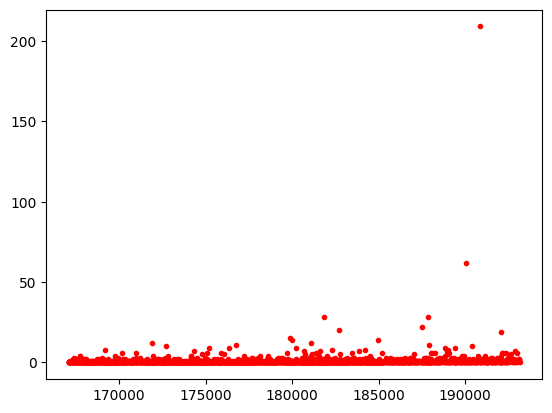

In [294]:
plt.plot(usefful_sorted['useful'],'r.')

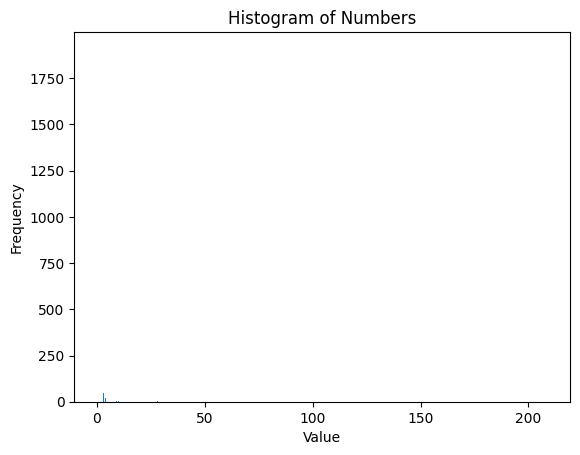

In [295]:
# Plotting the histogram
plt.hist(reviews['useful'], bins='auto')  # 'auto' lets matplotlib decide the number of bins
plt.title('Histogram of Numbers')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [290]:
l=reviews[reviews['review_id']=='HA0ZLe6xoyRIkrGQ8areXw']

In [291]:
print(l['text'])


190823    An American diner with a mixture of Hawaiian a...
Name: text, dtype: object


In [292]:
for i in l['text']:
    print(i)

An American diner with a mixture of Hawaiian and Mexican inspired menu is the locals favorite haunt. 

The atmosphere is casual and bustling with breakfast warriors rubbing elbows while getting their morning nourishments fixed. 

The best seat in the house may very well be at the bar where you can see all the happenings in the open kitchen concept. 

All the classics are featured with some served in an actual skillet. For those who are more health conscious, vegan options are available as well. 

We ordered a few of the most raved about items on Yelp. 

BISCUITS AND GRAVY
The biscuit to gravy ratio was off. The sausage gravy was devoid of any flavors and wasn't enough to completely soaked the biscuit thus leaving it a bit dry. Unfortunately, it was not a cohesive dish. 

HAWAIIAN BREAKFAST 
It included an egg, spam and Portuguese sausages with a scoop of macaroni salad and rice. The sausages were cooked to a crisp loosing the moisture it desperately needed. While this dish was hearty a

In [1]:
# OK. Now move on to prompt design (see N2 - test chatGPT models and prompt design..ipynb)